In this notebook, we approximate a continuous-time dynamical system which has the same physical measure as the Van der Pol oscillator with $c = 0.5$. The velocity $v = v(\theta)$ is paramaterized by global polynomials with coefficients $\theta$, and the $L^2$ cost between the ground truth invariant measure $\rho^*$ and the regularized PDE forward model $\rho_{\varepsilon}(v(\theta))$ is minimized. 



First, let's import some packages.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix, identity,spdiags, linalg
from scipy.sparse.linalg import LinearOperator,eigs,spsolve,norm
from scipy.optimize import minimize
from google.colab import output
from time import time
from numpy.random import default_rng
import math

Let's begin by establishing the experiment parameters

In [ ]:
G = {
"dt": .01, #timestep
"dx": .2, #spatial discretization
'bounds': [[-4,4],[-4,4]], #bounds used in discretization
"alpha": 1e-8, #teleportation parameter
"diff": 5e-2, #diffusion parameter
'TSMax': 1e5, #number of steps for inference time trajectory
'basis_deg': 3 #what degree polynomial basis to learn from
}

hist_bounds = G['bounds']
hist_bounds[0][0]-= G['dx']/2
hist_bounds[0][1]+= G['dx']/2
hist_bounds[1][0]-= G['dx']/2
hist_bounds[1][1]+= G['dx']/2

bounds = G['bounds']
#cell centers
Xi=np.array([i for i in np.arange(bounds[0][0], bounds[0][1]+G["dx"],G["dx"])])
Yi=np.array([i for i in np.arange(bounds[1][0], bounds[1][1]+G["dx"],G["dx"])])
#cell faces
Xf=[i-G["dx"]/2 for i in np.arange(bounds[0][0], bounds[0][1]+ G["dx"] + G["dx"] ,G["dx"])] 
Yf=[i-G["dx"]/2 for i in np.arange(bounds[1][0], bounds[1][1]+ G["dx"] + G["dx"] ,G["dx"])]
#number of cells
G['nx'] = len(Xi) 
G['ny']  = len(Yi)
#cell centers + ghost cells
Xi_int=[i for i in np.arange(bounds[0][0], bounds[0][1]+2*G["dx"],G["dx"])]
Yi_int=[i for i in np.arange(bounds[1][0], bounds[1][1]+2*G["dx"],G["dx"])]


Now we generate the inference data, i.e., form a histogram approximation of the Van der Pol oscillator's invariant measure using a long Euler-Maruyama trajectory.

time step: 10000 Elapsed time: 0.45s
time step: 20000 Elapsed time: 1.17s
time step: 30000 Elapsed time: 1.76s
time step: 40000 Elapsed time: 2.64s
time step: 50000 Elapsed time: 3.18s
time step: 60000 Elapsed time: 3.64s
time step: 70000 Elapsed time: 4.41s
time step: 80000 Elapsed time: 4.97s
time step: 90000 Elapsed time: 5.49s


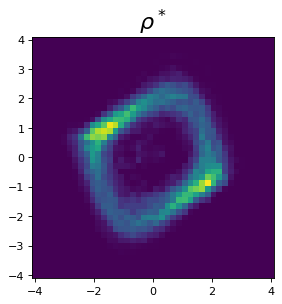

In [ ]:
def hist(ys,G,bounds):
     P, edges = np.histogramdd(ys , range = bounds, bins = [G['nx'],G['ny']],normed=True)
     P = P/sum(P.flatten())
     return P
 
def RHS_stand(x):
    vx = x[1]
    vy = .5*(1-x[0]**2)*x[1]-x[0]
    f = np.array((vx,vy)).reshape(1,2)
    return f
TimeStepMax = G['TSMax']
ys, ysn= np.zeros((int(TimeStepMax),2)),np.zeros((int(TimeStepMax),2))
ys[0,:] = [.1,.1]
tic = time()
noiseV = np.random.normal(0,1,int(2*TimeStepMax)).reshape((int(TimeStepMax),2))  
for timestep in range(1,int(TimeStepMax)): 
    if timestep% int(TimeStepMax/10)==0:
      toc = time()
      print(f'time step: {timestep:4d} Elapsed time: {toc-tic:.2f}s')
    ys[timestep,:] = ys[timestep-1,:] + G["dt"]* RHS_stand(ys[timestep-1,:]) +np.sqrt(2*G['diff']*G['dt'])*noiseV[timestep-1,:]

Peq_true = hist(ys,G,hist_bounds)
plt.figure(dpi = 80)
plt.title(r'$\rho^*$',fontsize = 20)
extent = (bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1])
plt.imshow(Peq_true.T,origin = 'lower',extent = extent)
Peq_true = Peq_true.flatten(order = 'F')

Now, we define the forward model and check that for the true velocity $v^*$ the approximation $\rho_{\varepsilon}(v^*)$ is reasonable.

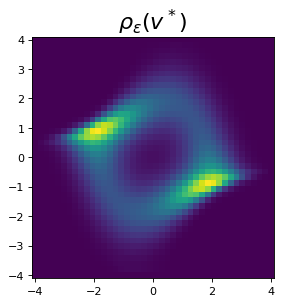

In [ ]:
nx,ny = G['nx'],G['ny']

####Create True Velocities
def RHS_vec(y,G):
  n,_ = np.shape(y)
  f1 = y[:,1]
  f2 =0.5*(1-y[:,0]**2)*y[:,1]-y[:,0]
  f = np.concatenate((f1.reshape(n,1),f2.reshape(n,1)),axis=1)
  return f

def build_velocities(G):
  Vx = np.zeros((nx+1, ny+1))
  Vy = np.zeros((nx+1, ny+1))   
  y_big = np.zeros((nx-1,ny-1,2)) 
  y_big[:,:,0],y_big[:,:,1] = np.meshgrid(Xf[1:-1],Yf[1:-1],indexing='ij')
  #y_big is n by 3 where n= (nx-1)*(ny-1)*(nz-1) is # of points we evaluate the RHS
  y_big = y_big.reshape(((nx-1)*(ny-1),2)) 
  # evaluate the velocity at faces of the velocity cells
  Vx[1:-1,1:-1] = np.reshape(RHS_vec(y_big + np.ones(((nx-1)*(ny-1),1))@np.array([0,G['dx']/2]).reshape(1,2), G)[:,0], ((nx-1),(ny-1)))
  Vy[1:-1,1:-1] = np.reshape(RHS_vec(y_big + np.ones(((nx-1)*(ny-1),1))@np.array([G['dx']/2,0]).reshape(1,2), G)[:,1], ((nx-1),(ny-1)))
  return Vx, Vy

G['Vx'], G['Vy'] = build_velocities(G) #ground truth discretization of velocity

###########Solve Forward Problem
def diffmin(x):
    return 1.*(x<0)
def diffmax(x):
    return 1.*(x>0)

def RHS_Matrix2 (G,bounds):     #Build sparse time advance operator K_mat
    Uf = G['Vx']
    Vf = G['Vy']
    up = np.maximum(Uf,0)
    un = np.minimum(Uf,0)
    vp = np.maximum(Vf,0)
    vn = np.minimum(Vf,0)
    N=nx*ny
    XXf,YYf= np.meshgrid(Xf,Yf,indexing='ij')
    ufm = Uf[:-1,:-1]
    ufm = ufm.flatten(order='F')
    ufp = Uf[1:,:-1]
    ufp = ufp.flatten(order='F')
    vfm = Vf[:-1,:-1]
    vfm = vfm.flatten(order='F')
    vfp = Vf[:-1,1:]
    vfp = vfp.flatten(order='F')
    #set diffusion terms while enforcing the zero-flux boundary condition
    DxR,DxL,DxC = np.ones((nx,ny)),np.ones((nx,ny)),-2*np.ones((nx,ny))
    DyR,DyL,DyC = np.ones((nx,ny)),np.ones((nx,ny)),-2*np.ones((nx,ny))
    DxR[-1,:],DxL[0,:],DyR[:,-1], DyL[:,0] = 0,0,0,0
    DxC[0,:],DxC[-1,:], DyC[:,0],DyC[:,-1] = -1,-1,-1,-1
    DxR,DxL,DxC,DyR,DyL,DyC = G['diff']*DxR.flatten(order = 'F'),G['diff']*DxL.flatten(order = 'F'),G['diff']*DxC.flatten(order = 'F'),G['diff']*DyR.flatten(order = 'F'),G['diff']*DyL.flatten(order = 'F'),G['diff']*DyC.flatten(order = 'F')
    T1 = spdiags(np.array([np.maximum(0,ufp)+DxR/G['dx'], np.minimum(0,ufm)- np.maximum(0,ufp)+DxC/G['dx'], -np.minimum(0,ufm)+DxL/G['dx']]), np.array([-1,0,1]), N, N) 
    T2 = spdiags(np.array([np.maximum(0,vfp)+DyR/G['dx'], np.minimum(0,vfm)- np.maximum(0,vfp)+DyC/G['dx'], -np.minimum(0,vfm)+DyL/G['dx']]), np.array([-nx,0,nx]), N, N)
    K_mat = (T1 + T2) /G['dx']*G['dt']
    return  K_mat

def FWD(G,bounds):  
    K_mat = RHS_Matrix2(G,bounds)
    K_mat = K_mat.tocsr()
    mnV = abs(K_mat.min(axis=0).min())       
    N = K_mat.shape[0]
    speyeN = identity(N).tocsr()
    M = speyeN +(1/(2*mnV))*K_mat
    e = np.ones(N,)
    A = (1-G["alpha"])*M - speyeN
    b = -(G["alpha"]/N)*e
    x = spsolve(A, b )
    Peq = x.reshape((G['nx'],G['ny']), order='F')
    Peq0 = Peq * 0
    Peq0[1:-1, 1:-1] = Peq[1:-1, 1:-1]
    Peq0 = Peq0/Peq0.sum()
    Peq0 = Peq0.flatten(order = 'F')
    # return the transpose of matrix (1-G["alpha"])*M - speyeN for adjoint eqn.
    return (1-G["alpha"])*M.transpose() - speyeN, Peq0, x, K_mat

_,Peq_epsilon,_,_ = FWD(G,bounds)
Peq_epsilon = Peq_epsilon.reshape(nx,ny,order = 'F')
plt.figure(dpi = 80)
plt.title(r'$\rho_{\varepsilon}(v^*)$',fontsize = 20)
plt.imshow(Peq_epsilon.T,origin = 'lower',extent = extent)

There is clearly significant numerical diffusion for the large spatial discretization we have chosen. For improved results, the mesh should be refined. Next, we will initialize a guess of 1e-4 for each polynomial coefficient and set up the adjoint-state method gradient calculation.

In [ ]:
d = 2
bnums = int(math.factorial(d+G['basis_deg'])/(math.factorial(G['basis_deg'])*math.factorial(d)))
G['basis1'] = np.ones(bnums)*1e-4
G['basis2'] = G['basis1'].copy()
basis_guess = np.concatenate((G['basis1'].flatten(),G['basis2'].flatten())) #initial coefficients guess

l = len(G['basis1'])
degs = []
xcount = 0
ycount = 0
for xs in range(G['basis_deg']+1):
    for ys in range(G['basis_deg']+1):
        if xs+ys <= G['basis_deg']:
            degs.append([xs,ys])
degs = np.asarray(degs) #helps index terms in the gradient calculation

def calc_cost_only(G,bounds,Peq_true):
    _,Peq, _,_ = FWD(G,bounds)
    cost = np.linalg.norm(Peq - Peq_true)**2 *0.5
    return cost

def calc_cost_gradient(G,bounds,Peq_true):
    #### 1. Solve the forward problem
    A,Peq,_,K_mat = FWD(G,bounds)
    #### 2. compute the loss function
    cost = np.linalg.norm(Peq - Peq_true)**2 *0.5
    u = Peq-Peq_true 
    #### 3. Solve the adjoint equation
    sol = spsolve(A,-u + u.dot(Peq))
    #### 4. compute the gradient
    grad = np.zeros((l,2))
    mnV = abs(K_mat.min(axis=0).min())
    for i in range(1,nx-1):
      for j in range(1,ny-1):
        idx = i + nx*j
        dv1, dv2 = 1,1
        v1, v2 = G['Vx'][i,j], G['Vy'][i,j]
        g1 = ((G['dt']*(1-G["alpha"])*(1/(2*mnV))*(sol[idx]-sol[idx-1])*(diffmax(v1)*Peq[idx-1]+diffmin(v1)*Peq[idx])*dv1/G['dx'])) 
        g2 = ((G['dt']*(1-G["alpha"])*(1/(2*mnV))*(sol[idx]-sol[idx-nx])*(diffmax(v2)*Peq[idx-nx]+diffmin(v2)*Peq[idx])*dv2/G['dx']))
        grad[:,0] += g1*(Xf[i]**(degs[:,0]))*(Yi[j]**(degs[:,1]))
        grad[:,1] += g2*(Xi[i]**(degs[:,0]))*(Yf[j]**(degs[:,1]))  
    return cost,grad
  
def grad1(basis): #reformat gradient computation above to be compatible with scipy.minimize
    G['basis1'] = basis[:l]
    G['basis2'] = basis[l:]      
    G['Vx'], G['Vy'] = build_velocities_basis(G)
    g = np.zeros((l,2))
    c,g = calc_cost_gradient(G,bounds,Peq_true)
    return g.flatten(order = 'F')

def cost1(basis): #reformat cost calculation above to be compatible with scipy.minimize
    G['basis1'] = basis[:l]
    G['basis2'] = basis[l:]
    G['Vx'], G['Vy'] = build_velocities_basis(G)
    c = calc_cost_only(G,bounds,Peq_true)
    return c

Finally, we run L-BFGS-B optimization for 50 iterations to recover the true velocity. 

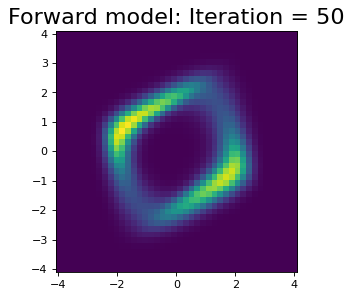

In [ ]:
def RHS_vec_basis(y,G):
    n,_ = np.shape(y)
    f1, f2 = np.zeros(n), np.zeros(n)    
    b1 = G['basis1'].flatten()
    b2 = G['basis2'].flatten()
    for i in range(len(b1)):
        f1 += b1[i]*y[:,0]**(degs[i][0])*y[:,1]**(degs[i][1])
        f2 += b2[i]*y[:,0]**(degs[i][0])*y[:,1]**(degs[i][1])
    f = np.concatenate((f1.reshape(n,1),f2.reshape(n,1)),axis=1)
    return f
    
def build_velocities_basis(G):  #translates polynomial coefficients to the corresponding vector field
  Vx = np.zeros((nx+1, ny+1))
  Vy = np.zeros((nx+1, ny+1))   
  y_big = np.zeros((nx-1,ny-1,2)) 
  y_big[:,:,0],y_big[:,:,1] = np.meshgrid(Xf[1:-1],Yf[1:-1],indexing='ij')
  #y_big is n by 3 where n= (nx-1)*(ny-1)*(nz-1) is # of points we evaluate the RHS
  y_big = y_big.reshape(((nx-1)*(ny-1),2)) 
  # evaluate the velocity at faces of the velocity cells
  Vx[1:-1,1:-1] = np.reshape(RHS_vec_basis(y_big + np.ones(((nx-1)*(ny-1),1))@np.array([0,G['dx']/2]).reshape(1,2), G)[:,0], ((nx-1),(ny-1)))
  Vy[1:-1,1:-1] = np.reshape(RHS_vec_basis(y_big + np.ones(((nx-1)*(ny-1),1))@np.array([G['dx']/2,0]).reshape(1,2), G)[:,1], ((nx-1),(ny-1)))
  return Vx, Vy

Iterations = 0
def callback(basis):
    global Iterations 
    G['basis1'] = basis[:l]
    G['basis2'] = basis[l:]
    G['Vx'], G['Vy'] = build_velocities_basis(G)
    if Iterations%10==0 :
        _,Peq,_,_ = FWD(G,bounds)
        Peq = Peq.reshape(nx,ny,order = 'F')
        output.clear()
        plt.figure(dpi = 80)
        plt.title('Forward model: Iteration = {}'.format(Iterations),fontsize = 20)
        plt.imshow(Peq.T,origin = 'lower',extent = extent)
        plt.show()
    Iterations = Iterations+1
    return 

  
opt = minimize(cost1,
         basis_guess, 
         method='L-BFGS-B', 
         jac=grad1, 
         bounds = None,
         callback = callback,
         options={'maxiter': 51})

Clearly there has been some overfitting, as the forward model with the learned velocity matches the ground truth invariant measure more closely than the forward model evaluated at the ground truth velocity. These errors are expected to decrease as the mesh is refined.